In [1]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
from sklearn.cluster import KMeans
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


2023-10-26 12:02:41.653223: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1- Data Preprocessing

In [2]:
%%capture
# Read the data into a dataframe from a CSV

dataset = pd.read_csv('cc_data.csv')

In [3]:
%%capture
# Drop columns that wouldn't be needed or used

dataset.drop(['Time','Class'], axis=1, inplace=True)

In [4]:
#dropping the last row
dataset = dataset[:284807]

In [5]:
%%capture
# Scaling the Data 
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()

scld_data1 = scaler1.fit_transform(dataset)
scld_data2 = scaler2.fit_transform(dataset)
scld_data3 = scaler3.fit_transform(dataset)

In [6]:
%%capture
# Splitting the data

# Standard Scaler Data
ss_train, ss_temp = train_test_split(scld_data1, test_size= 0.3)
ss_val, ss_test = train_test_split(ss_temp, test_size=0.8)

# MinMax scaler Data
ms_train, ms_temp = train_test_split(scld_data2, test_size= 0.3)
ms_val, ms_test = train_test_split(ms_temp, test_size=0.8)

# Robust scaler Data 
rs_train, rs_temp = train_test_split(scld_data3, test_size= 0.3)
rs_val, rs_test = train_test_split(rs_temp, test_size=0.8)

#### 2- Building autoencoder

In [7]:
%%capture
# Autoencoder 1 Design

input_dim = ss_train.shape[1]
encoding_dim = 15

autoencoder = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),                 #input layer
    keras.layers.Dense(encoding_dim, activation='relu'),    #encoder layer
    keras.layers.Dense(input_dim, activation='sigmoid')     #decoder layer
])

autoencoder.compile(optimizer='adam', loss='mean_squared_error') #Compiler
fit_results = autoencoder.fit(ss_train, ss_train, epochs=100, batch_size=64, validation_data=(ss_val, ss_val)) #Autoencoder Training

#### 3- Classification Task

In [8]:
# Encoding test data

encoder1 = keras.Model(inputs = autoencoder.input, outputs = autoencoder.layers[1].output)
encoded_test_Data = encoder1.predict(ss_test)

2137/2137 [==============================] - 2s 975us/step


In [9]:
#fit kmeans on the encoded data

classifier = KMeans(n_clusters=2)
classifier.fit(encoded_test_Data)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2)

In [10]:
#Cluster Assignment
cluster_assignment = classifier.predict(encoded_test_Data)

#### 4- Performance Evaluation and Visualization

In [11]:
#Saving Perfromance data from the training history
loss = fit_results.history['loss']
val_loss = fit_results.history['val_loss']

In [12]:
#create list of index for epochs
rng = 100
index_lst = []
for i in range(1,rng+1):
    index_lst.append(i)

In [13]:
#create dataframe for performance data
per_eval = pd.DataFrame(index_lst)
per_eval['t_loss'] = loss
per_eval['v_loss'] = val_loss
per_eval.rename(columns={0:'epochs'}, inplace=True)
per_eval

,epochs,t_loss,v_loss
0,1,0.836511,0.773710
1,2,0.752425,0.754426
2,3,0.741429,0.747542
3,4,0.735283,0.742678
4,5,0.731090,0.739416
...,...,...,...
95,96,0.715673,0.725156
96,97,0.715684,0.725133
97,98,0.715712,0.725244
98,99,0.715669,0.725172


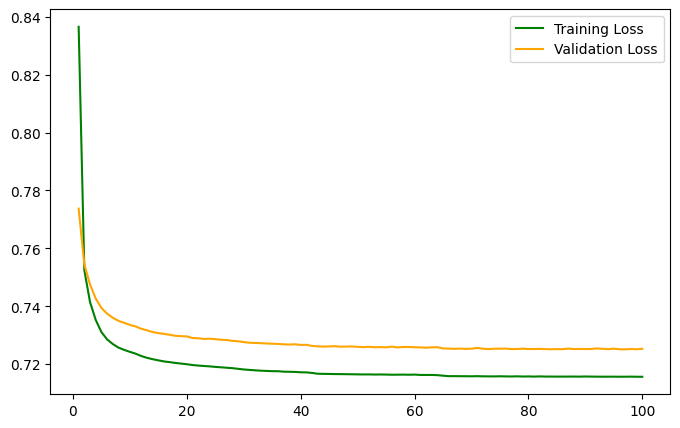

In [14]:
#plot the performance data
plt.figure(figsize=(8,5))
plt.plot(per_eval['epochs'],per_eval['t_loss'], c='green', label = 'Training Loss')
plt.plot(per_eval['epochs'],per_eval['v_loss'], c='orange', label = 'Validation Loss')
plt.legend()


#### 5- Result interpretation and Visualization

<p>
the goal of the unsupervised learning autoencoder is to see if it can learn the data well and seperate between two classes (Fraud or no Fraud). 
Bases on the visualization we can see that the autoencoder is able to distinguish between our two classes pretty well. There are some outliers but over the performance is good.
Further work will need to done for labeling the outcome. 
</p>

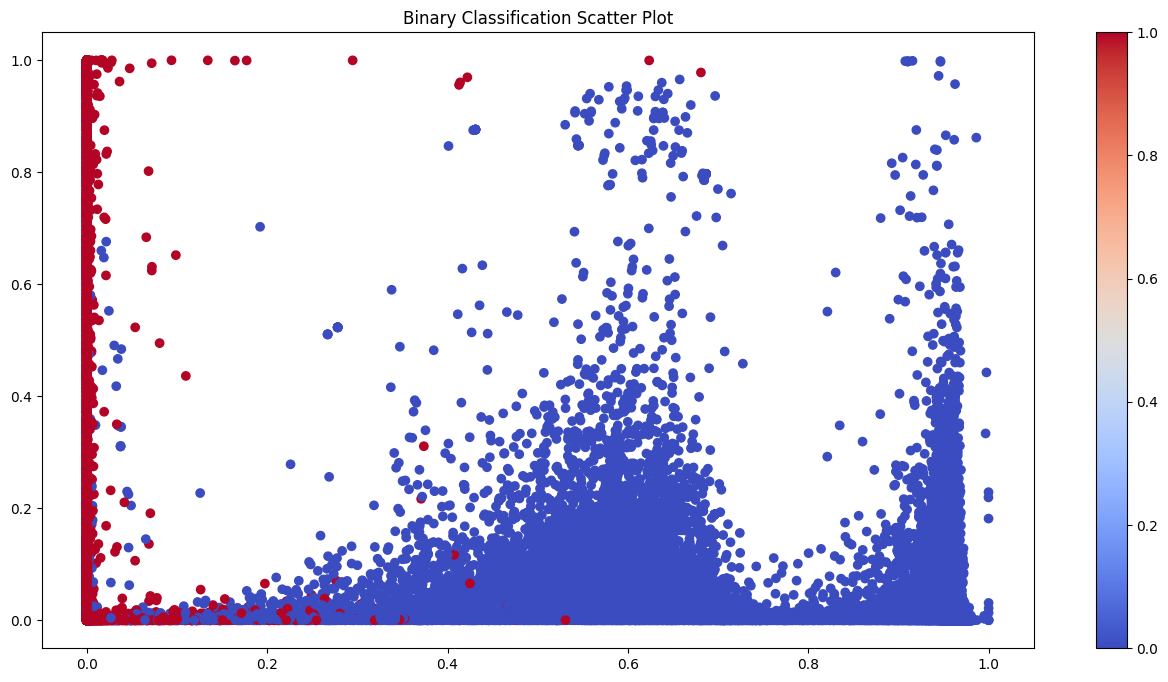

In [15]:
plt.figure(figsize=(16,8))
plt.scatter(encoded_test_Data[:, 0], encoded_test_Data[:, 1], c=cluster_assignment, cmap='coolwarm' )
plt.colorbar()
plt.title('Binary Classification Scatter Plot')
plt.show()